# Описание проекта :
Сервис аренды самокатов GoFast передал данные о некоторых пользователях из нескольких городов, а также об их поездках. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

    - без подписки: 
        - абонентская плата отсутствует;
        - стоимость одной минуты поездки — 8 рублей;
        - стоимость старта (начала поездки) — 50 рублей;
    - с подпиской Ultra:
        - абонентская плата — 199 рублей в месяц;
        - стоимость одной минуты поездки — 6 рублей;
        - стоимость старта — бесплатно.

# Описание задачи 

1. Посчитать совокупную выкучку за год по всем пользователям
2. Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов и проверить следующие гипотезы:
   
   -  Проверить гипотезу о том,что  пользователи с подпиской тратят больше времени на поездки?
   -  Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
   -  Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
   -  Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.
   -  Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from scipy.stats import binom,norm,poisson
from math import factorial,exp,sqrt
from statsmodels.stats.weightstats import ttest_ind

sns.set_palette('pastel')
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# функция отображения признака в зависимости от целевого
def plot_feature_tag (df,col,tag):
    
    plt.figure(figsize=(8, 8))
    if tag != 0 :  sns.histplot(y=col, data=df,hue =tag)
    else : sns.histplot(y=col, data=df)
    plt.tight_layout()    
    plt.show()
    return()  

In [3]:
def hist (df,featur,tag):
    display(featur)
    fig, (ax_box, ax_hist) = plt.subplots(2,sharex=True, gridspec_kw={"height_ratios": (0.20, 0.80)},figsize=(10, 10)) 
    sns.boxplot(x=df[featur], ax=ax_box)
    if tag != 0 : sns.histplot(data=df,x=featur, bins=100, hue=tag)
        
    else: sns.histplot(df[featur], bins=100)
    ax_box.set(xlabel="")
    ax_hist.set(xlabel=featur)
    ax_hist.set(ylabel="Count")
    plt.tight_layout()
    plt.show()
    return() 

#  Загрузка данных

In [4]:
DATA_PATHS = {
    'users': 'users_go.csv',
    'rides': 'rides_go.csv', 
    'subscriptions': 'subscriptions_go.csv'
}

data_user = pd.read_csv(DATA_PATHS['users'])
data_rid = pd.read_csv(DATA_PATHS['rides'])
data_sub = pd.read_csv(DATA_PATHS['subscriptions'])

dat_name=[data_user,data_rid,data_sub]
for d in dat_name:
    d.info()
    display (d.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,"4,409.92",25.60,2021-01-01
1,1,"2,617.59",15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,"2,694.78",18.51,2021-08-11
4,1,"4,028.69",26.27,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


## Описание данных 
В основных данных есть информация о пользователях, их поездках и подписках.

    * Пользователи — users_go.csv (кол-во записей 1565):    
        - user_id уникальный идентификатор пользователя
        - name имя пользователя
        -  age возраст
        -  city город
        -  subscription_type тип подписки (free, ultra)
    
    * Поездки — rides_go.csv (кол-во записей 18068):
     
     -  user_id уникальный идентификатор пользователя
     -  distance расстояние, которое пользователь проехал в текущей сессии (в метрах)
     -  duration продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
     -  date дата совершения поездки
     
    * Подписки — subscriptions_go.csv ( 2 записи):
    
     - subscription_type тип подписки
     - minute_price стоимость одной минуты поездки по данной подписке
     - start_ride_price стоимость начала поездки
     - subscription_fee стоимость ежемесячного платежа


## Предобработка данных

In [5]:
print('количество дубликатов в базе data_user',data_user.duplicated().sum())
display('Дубликаты в базе data_user',data_user[data_user.duplicated()==True])
display('Дубликаты в базе data_sub',data_sub[data_sub.duplicated()==True])
display('Дубликаты в базе data_rid',data_rid[data_rid.duplicated()==True])

# удаляем дубликаты в базе dat_user
data_user=data_user.drop_duplicates().copy()
data_rid['date']=data_rid['date'].astype('datetime64[ns]')

#display(data_rid.describe(include='all') )

# поскольку данные представлены в рамкамх одного года - дополним данные выделенным месяцкм
data_rid['month']=pd.to_datetime(data_rid['date'], format='%Y-%m-%d').dt.month




количество дубликатов в базе data_user 31


'Дубликаты в базе data_user'

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


'Дубликаты в базе data_sub'

,subscription_type,minute_price,start_ride_price,subscription_fee


'Дубликаты в базе data_rid'

,user_id,distance,duration,date


# Исследовательский анализ данных

## Анализ распределения клиентов городам

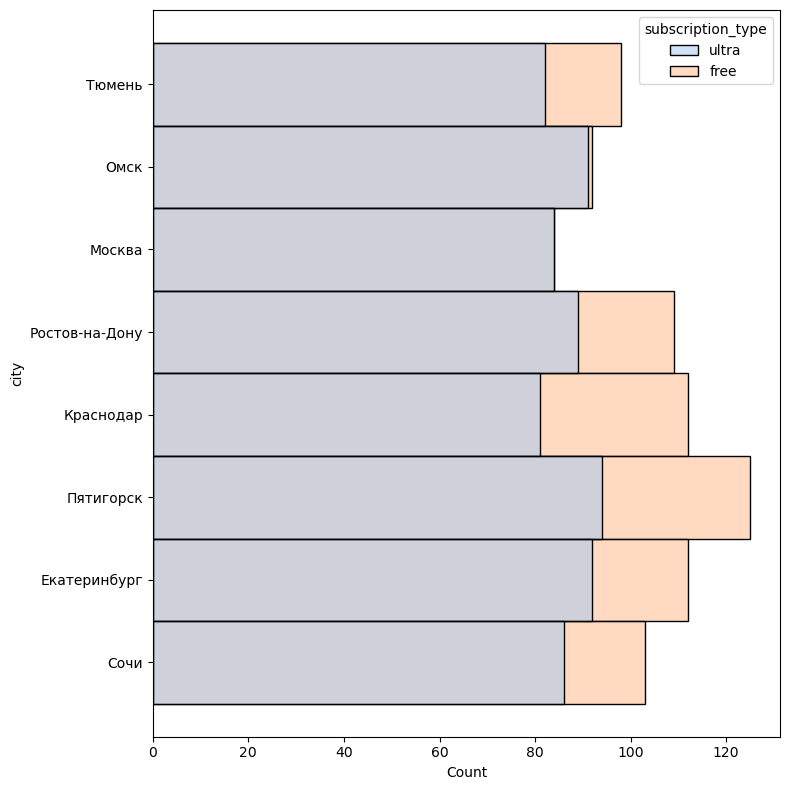

()

In [6]:
plot_feature_tag (data_user,'city','subscription_type')

- в базе предствалены пользователи из городов разной географической широты и разной численностью населения. Представлены более-менее равномерно : 1534 / 8 городов = 192, разброс от экстремальных значений 25- выборка репрезентативна по этому параметру , при учете принятия условия однородности городов.
- наибольшее количество пользователей в базе из Пятигорска - 219 человек.
- наименьшее количество пользователей в базе из Москвы - 168 человек.
- В Омске и Москве количество пользователей с подпиской и без приблизительно одинаковое


## Пользователи с подпиской и без 

Всего пользовтелей  1534 


([<matplotlib.patches.Wedge at 0x16e5d1f8e00>,
 [Text(-0.152693865829377, 1.0893505328121342, 'free'),
  Text(0.15269396782173408, -1.0893505185158978, 'ultra')],
 [Text(-0.08328756317966017, 0.5941911997157094, '54.43%'),
  Text(0.08328761881185494, -0.5941911919177624, '45.57%')])

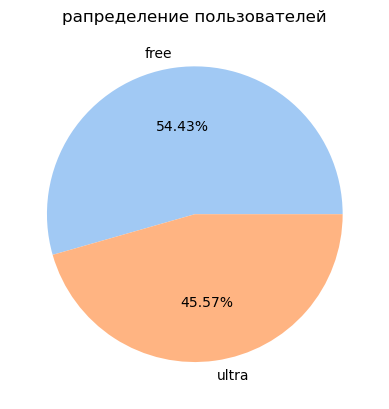

In [7]:
total_user=data_user['subscription_type'].count()

print('\033[1m'+'Всего пользовтелей ',total_user ,'\033[0m')

fig, ax = plt.subplots()
ax.set_title('рапределение пользователей')
sizes = data_user['subscription_type'].value_counts()
ax.pie(sizes, labels=sizes.index , autopct='%1.2f%%')





- соотношение элементов базы пользователей с подпиской  и без 45.57% / 54.43% . Приблизительно равномерны распределены -  можно сказать , что по этому параметру выборка репрезентативна

## Анализ  возраста пользователей

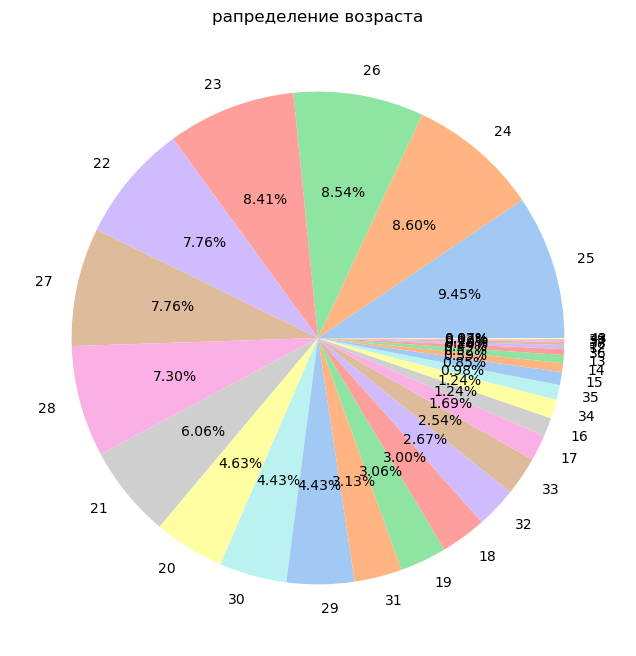

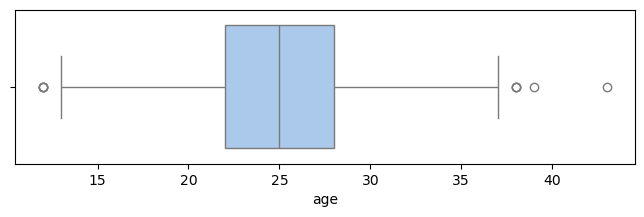

In [8]:

plt.figure(figsize=(8, 8))
plt.title('рапределение возраста')


plt.pie(data_user['age'].value_counts(), labels=data_user['age'].value_counts().index , autopct='%1.2f%%')
plt.show()
plt.figure(figsize=(8, 2))
sns.boxplot(x=data_user['age'])
plt.show()

- распределение клиентов по возрасту близко к нормальному - выборка репрезентативна по данному параметру
- нет пользователей старше 43 лет. Границу осечения можно провести и по 36 годам: количество клиентов старше не значительно 
- оценивая максимальные и минимальные значения выявлены группы пользователей младше 14 лет. Хотя по ПДД пользоваться самостоятельно они могут самокатами, однако фирмы проката в правилах прописали совершенолетний ценз. Сообщить заказчику о данной группе

## Анализ поездок пользователей

In [9]:
data_rid['speed_avg']=(data_rid['distance']/1000)/(data_rid['duration']/60)
data_rid['user_id'][data_rid['duration']<=0.5].nunique()
# data_rid = data_rid[data_rid['duration']>0.5].copy()
data_rid[data_rid['duration']<=0.5]
#data_rid[data_rid['user_id']==701]

,user_id,distance,duration,date,month,speed_avg
6531,701,"4,196.45",0.50,2021-08-31,8,503.57
6570,704,"4,830.82",0.50,2021-10-14,10,579.70
6680,712,"4,684.00",0.50,2021-03-04,3,562.08
6695,713,"5,215.64",0.50,2021-02-25,2,625.88
6768,718,"5,197.44",0.50,2021-02-11,2,623.69
...,...,...,...,...,...,...
17004,1460,"5,531.34",0.50,2021-01-19,1,663.76
17242,1477,"6,724.93",0.50,2021-01-12,1,806.99
17314,1483,"4,445.48",0.50,2021-03-06,3,533.46
17505,1496,"5,722.55",0.50,2021-02-14,2,686.71


 В ходе исследования выявленна группа значений у которых ошибочно указанно время пользования - у всех 0.5 минут. 

### Анализ расстояний

'Описательная статистика поездок '

,user_id,distance,duration,date,month,speed_avg
count,"18,068.00","18,068.00","18,068.00",18068,"18,068.00","18,068.00"
mean,842.87,"3,070.66",17.81,2021-06-30 19:47:21.266327296,6.49,13.79
min,1.00,0.86,0.50,2021-01-01 00:00:00,1.00,0.01
25%,487.00,"2,543.23",13.60,2021-04-02 00:00:00,4.00,8.13
50%,889.00,"3,133.61",17.68,2021-06-30 00:00:00,6.00,10.25
75%,"1,213.25","3,776.22",21.72,2021-09-28 00:00:00,9.00,12.93
max,"1,534.00","7,211.01",40.82,2021-12-30 00:00:00,12.00,865.32
std,434.73,"1,116.83",6.09,NaN,3.44,44.16


'поездки с расстоянием менее 5 м'

,user_id,distance,duration,date,month,speed_avg
11555,1069,0.86,10.00,2021-01-31,1,0.01
13690,1223,4.33,4.01,2021-05-22,5,0.06
9541,925,2.57,3.01,2021-10-19,10,0.05


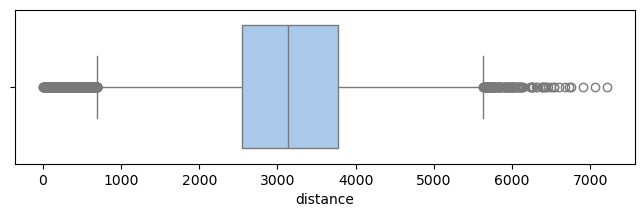

In [10]:
display('Описательная статистика поездок ', data_rid.describe())
display ('поездки с расстоянием менее 5 м',data_rid[data_rid['distance']<= 5].sort_values('date',ascending=True))


#hist (data_rid,'distance','month')
plt.figure(figsize=(8, 2))
sns.boxplot(x=data_rid['distance'])
plt.show()


Выводы :
- за год пользователи берут в аренду самокат в среднем 12 раз.
- пользователи берут в аренду самокаты приблизительно равномерно по месяцам при учете по всем городам как по количеству поездок , так и по суммарным расстояниям
- среднее расстояние, которое проезжает клиент за один заказ - около 3100 м (среднее значение между медийным и арифметическим средним)
- есть значительная группа поездок с расстоянием менее 1500 м , которые можно выделить в отдельное исследование

### продолжительность поездок.

<Axes: xlabel='duration'>

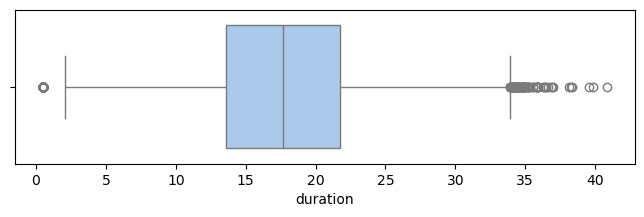

In [11]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=data_rid['duration'])

Выводы:
- пользователи не используют самокаты более 40 минут
- среднее время аренды - около 17.8 минут (округляя , получится 18 минут)


## Объединение данных

In [12]:

# размерность основной базы - 17973, после объединения должно быть не меньше
df_total=data_user.merge(data_rid, on='user_id', how='left' )
#df_total.info()
df_total=data_sub.merge(df_total, on='subscription_type', how='left' )
# округляем время до минут
df_total['duration'] = np.ceil(df_total['duration']).astype('int32') 
df_total[df_total['duration']<=1]

,subscription_type,minute_price,start_ride_price,subscription_fee,user_id,name,age,city,distance,duration,date,month,speed_avg
31,free,8,50,0,701,Иван,31,Екатеринбург,"4,196.45",1,2021-08-31,8,503.57
70,free,8,50,0,704,Мирон,29,Ростов-на-Дону,"4,830.82",1,2021-10-14,10,579.70
180,free,8,50,0,712,Дарья,28,Москва,"4,684.00",1,2021-03-04,3,562.08
195,free,8,50,0,713,Святослав,30,Краснодар,"5,215.64",1,2021-02-25,2,625.88
268,free,8,50,0,718,Владислава,31,Москва,"5,197.44",1,2021-02-11,2,623.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10504,free,8,50,0,1460,Жанна,27,Пятигорск,"5,531.34",1,2021-01-19,1,663.76
10742,free,8,50,0,1477,Ян,17,Сочи,"6,724.93",1,2021-01-12,1,806.99
10814,free,8,50,0,1483,Роберт,26,Екатеринбург,"4,445.48",1,2021-03-06,3,533.46
11005,free,8,50,0,1496,Яна,19,Москва,"5,722.55",1,2021-02-14,2,686.71


Распределение данных o пользователей с подпиской 11568 
 и без  6500 


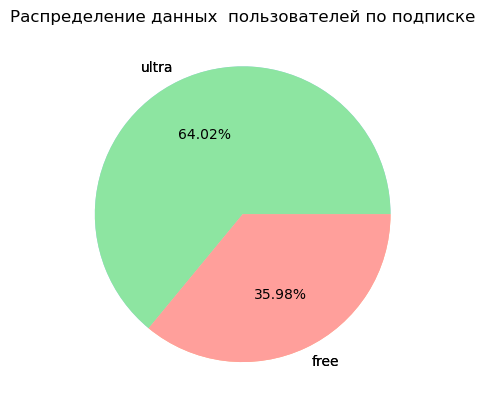

In [13]:
#количество пользователей с подпиской /без
s=df_total[df_total['subscription_type']=='ultra']['subscription_type'].count() 
w=df_total[df_total['subscription_type']=='free']['subscription_type'].count()

print('\033[1m'+'Распределение данных o пользователей с подпиской', w,'\n и без ',  s,'\033[0m')

fig, ax = plt.subplots()
#ax.set_title='рапределение пользователей' , w , s
labels = 'ultra', 'free'
sizes = [w ,s]
ax.pie(sizes, labels=labels, autopct='%1.2f%%')
ax.pie(sizes, labels=labels)
ax.set_title('Распределение данных  пользователей по подписке')
plt.show()


Выводы :
- объединение баз данных прошло успешно, элементы не потеряны
- разделение баз прошло успешно - сумма элементов равно общему количеству исходной базы
- в базе преобладают данные о поездках без подписки 68.83%/36.17%

## Визуализация информации о расстоянии и времени поездок для пользователей с подпиской и без

'duration'

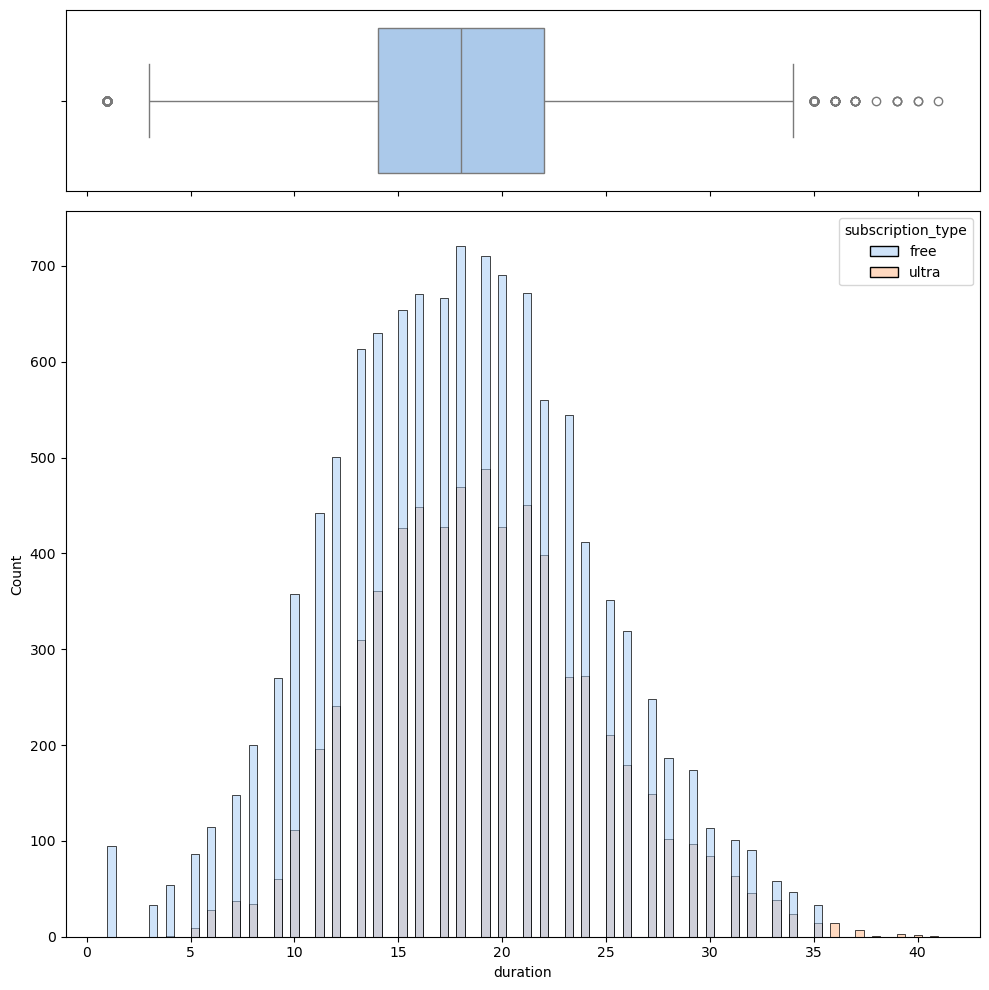

'distance'

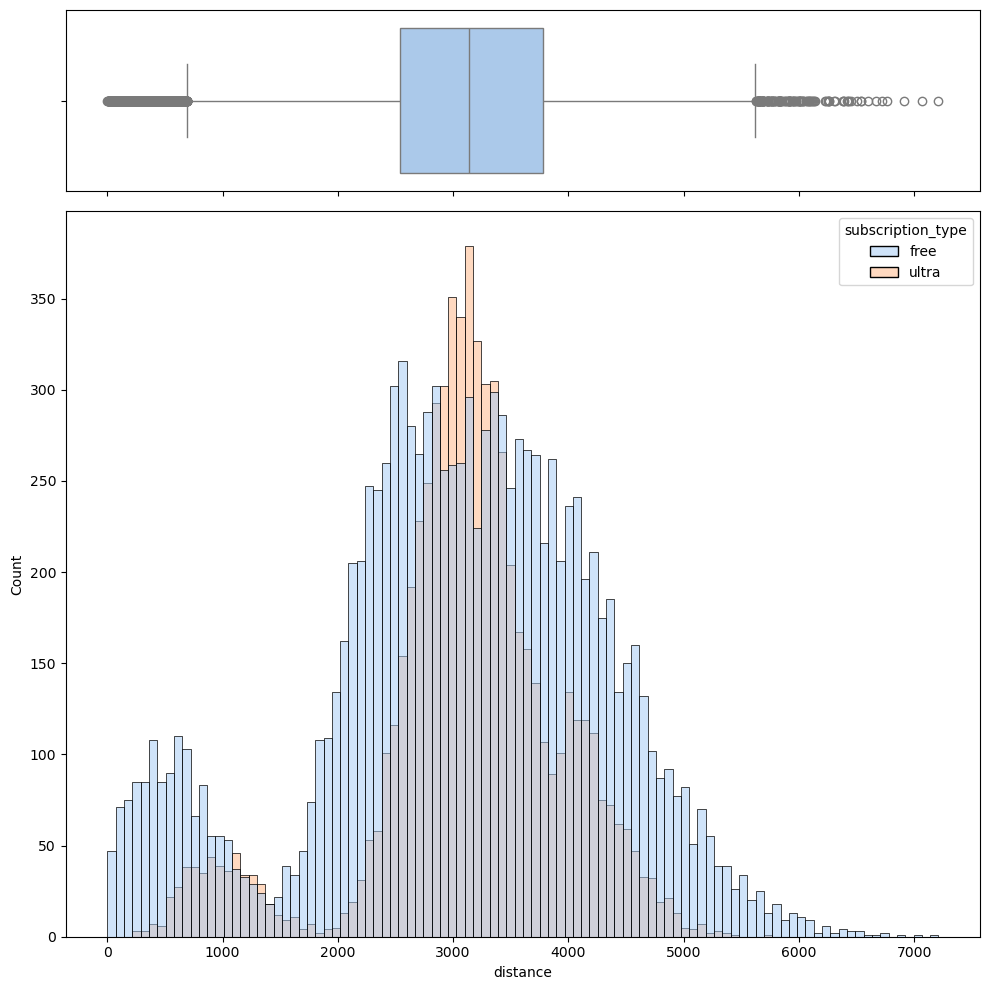

()

In [14]:
hist (df_total,'duration','subscription_type')
hist (df_total,'distance','subscription_type')

Выводы:
- количество поездок относительно времени у пользователей обоих групп разница присутствует, но, в целом, профили схожие
- пользовтели без подписки проезжают больше расстояний (на 1000 м) , чем без подписки
- наблюдается тенденция пользования самокатом на расстояния около 1 км - возможно стоит исследовать причины и зависимости появления "горба" на графике
- больший разброс по расстояниям и продолжительности поездок у пользователй без подписки


## Подсчёт выручки

In [15]:
data_c=df_total.groupby(['month','subscription_type'],as_index=False ).agg({'distance':['sum'],'duration':['sum','count']})
data_c.columns=['month','subscription_type','distance_sum','duration_sum','count']
# объеденяем с базой описания подписки и расчета
data_c=data_c.merge(data_sub, on='subscription_type', how='left' )
#ata_c.info()

# объединение - успешно


In [16]:
#Помесячная выручка считается по формуле: стоимость старта поездки××  количество поездок +
# + стоимость одной минуты поездки ×× общая продолжительность всех поездок в минутах + стоимость подписки.

#data_c['subscription_type']=data_c['subscription_type'].apply(lambda x: 1 if x =='ultra'  else 0)
data_c['m_cost'] = data_c['start_ride_price']*data_c['count'] + \
                   data_c['minute_price'] * data_c['duration_sum'] + \
                   data_c['subscription_fee'] *data_c['count'] 
data_c['cost_mean']=data_c['m_cost']/data_c['count']
tot_ultra = data_c[data_c['subscription_type']=='ultra']['m_cost'].sum()
tot_free = data_c[data_c['subscription_type']=='free']['m_cost'].sum()
tot_all = data_c['m_cost'].sum()
display(data_c.head())
print ('\033[1m'+'Общая выручка за год по всем клиентам ULTRA ', tot_ultra,'рублей' +'\033[0m')
print ('\033[1m'+'Общая выручка за год по всем клиентам FREE ',tot_free,'рублей' +'\033[0m')
print ('\033[1m'+'Общая выручка за год по всем клиентам',tot_all,'рублей' +'\033[0m')


,month,subscription_type,distance_sum,duration_sum,count,minute_price,start_ride_price,subscription_fee,m_cost,cost_mean
0,1,free,"3,100,236.49",17975,1001,8,50,0,193850,193.66
1,1,ultra,"1,797,157.59",11083,584,6,0,199,182714,312.87
2,2,free,"2,625,061.89",15307,868,8,50,0,165856,191.08
3,2,ultra,"1,451,161.34",9021,468,6,0,199,147258,314.65
4,3,free,"2,944,074.73",17258,983,8,50,0,187214,190.45


Общая выручка за год по всем клиентам ULTRA  2035970 рублей
Общая выручка за год по всем клиентам FREE  2234104 рублей
Общая выручка за год по всем клиентам 4270074 рублей


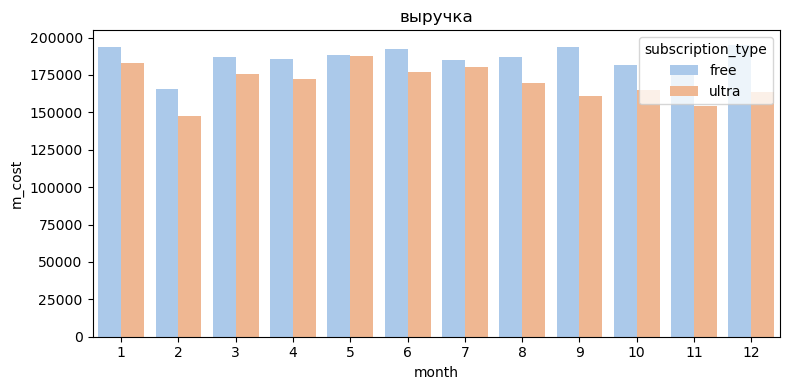

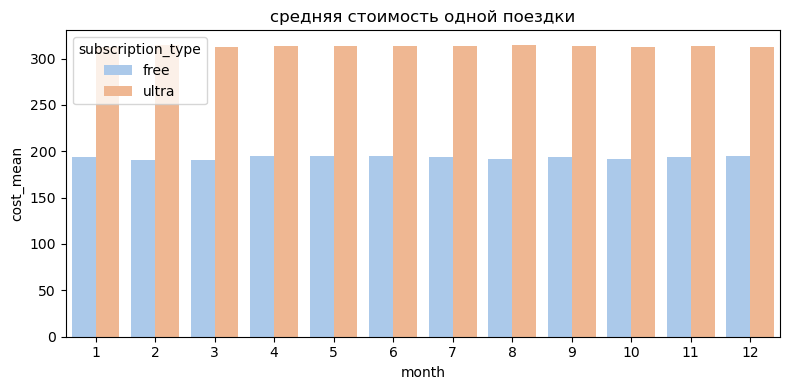

In [17]:
plt.figure(figsize=(8, 4))
plt.title('выручка')
sns.barplot(x= 'month', y='m_cost', data=data_c,hue ='subscription_type')
plt.tight_layout()    
plt.show()

plt.figure(figsize=(8, 4))
plt.title('средняя стоимость одной поездки')
sns.barplot(x= 'month', y='cost_mean', data=data_c,hue ='subscription_type')
plt.tight_layout()    
plt.show()




Выводы :

- в среднем,пользователи без подписки тратят на одну поездку около 190 рублей, с подписко - около 310


## Проверка гипотез

In [18]:
# удалим ошибочные данные по времени 0.5 мин 
# данные с пользователями с подпиской
df_tot = df_total[df_total['duration']>1].copy()
ds_s=df_tot[df_tot['subscription_type']=='ultra'].copy()
# данные с пользователями без подписки
ds_w=df_tot[df_tot['subscription_type']=='free'].copy()


### Гипотеза о том,что  пользователи с подпиской тратят больше времени на поездки

Проверим гипотезу :
- нулевая : пользователи с подпиской используют самокат по времени дольше, чем  пользователи без подписки
- альтернативная : пользователи с подпиской используют  самокат по времени  меньше  , чем пользователи без подписки


In [19]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(ds_w['duration'],ds_s['duration'], alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Не принимаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print(results)

p-значение: 8.577910347796266e-28
Не принимаем нулевую гипотезу
TtestResult(statistic=-10.881761649647034, pvalue=8.577910347796266e-28, df=17971.0)


#### Выводы:
- Нулевая гипотеза отвергнута, есть основания утверждать, что средняя продолжительность поездки с подпиской меньше продолжительности поездок без подписки

### Гипотеза о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

Проверим гипотезу :
- нулевая : пользователи с подпиской проезжают не более 3130 
- альтернативная : пользователи с подпиской проезжают больше 3130 


In [20]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу
dis_mark=3130
# используем порядок сравнения данных , согласно основной гипотезы: 
# дистанцию пользователей сравниваем со значение 3130, но меняем условие на обратное, чтобы не упустить тождества выборок

results = st.ttest_1samp(ds_s['distance'],dis_mark, alternative='greater')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


#### Вывод :
- нулевая гипотеза о значении "оптмального износа" равным 3130 принимается с вероятностью почти 92%
- данная гипотеза подтверждается другими стат данными, такими как среднее значение 3115 м и медийное 3148 

### Гипотеза о том, что помесячная выручка от пользователей с подпиской по месяцам будет выше, чем выручка от пользователей без подписки

Проверим гипотезу :
- нулевая : помесячная выручка от пользователей с подпиской  меньше выручки пользователей без подписки 
- альернативная: выручка больше у пользователей с подпиской

In [21]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

dc_ms=data_c[data_c['subscription_type']=='ultra']
dc_mw=data_c[data_c['subscription_type']=='free']

results = st.ttest_ind(dc_ms['m_cost'],dc_mw['m_cost'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
print(results)

p-значение: 0.9996696620607795
Не получилось отвергнуть нулевую гипотезу
TtestResult(statistic=-3.9626098134356202, pvalue=0.9996696620607795, df=22.0)


#### Вывод:
- Нулевая гипотеза не отвергнута,с вероятностью более 99%
- предыдущие графики это подтверждают

## Распределения

### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. 

Чтобы выполнить план в  100  клиентов с вероятностю 95% нужно раздать  1172  купонов


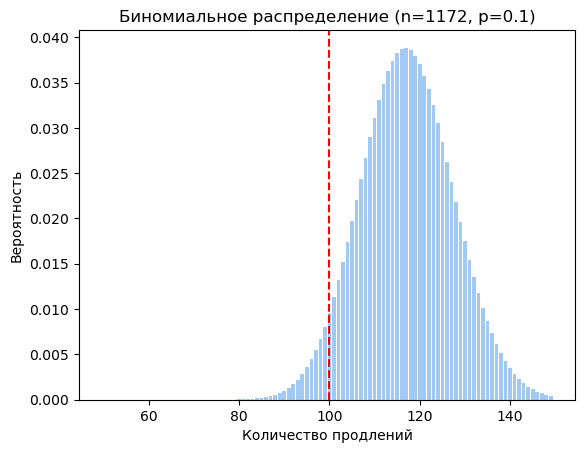

In [23]:
# описываем графиком распределение
col = 100 # количество попыток
p1 = 0.1 # вероятность успеха
x1 = np.random.binomial(col , p1, 1500 )

#sns.histplot(x1, kde=True,stat="density")
plt.show()
i=1000
p=0.05
while p< binom.cdf(k= col , n= i , p= p1 ):
    i=i+1

print('\033[1m'+'Чтобы выполнить план в ',col,' клиентов с вероятностю 95% нужно раздать ',i,' купонов'+'\033[0m')

# Визуализация
n = i
p = 0.1
x = np.arange(50, 150)
plt.bar(x, binom.pmf(x, n, p))
plt.axvline(100, color='red', linestyle='--')
plt.title(f'Биномиальное распределение (n={n}, p={p})')
plt.xlabel('Количество продлений')
plt.ylabel('Вероятность')
plt.show()

### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Вероятность открытий <= 399,500: 15.371708296369768 %


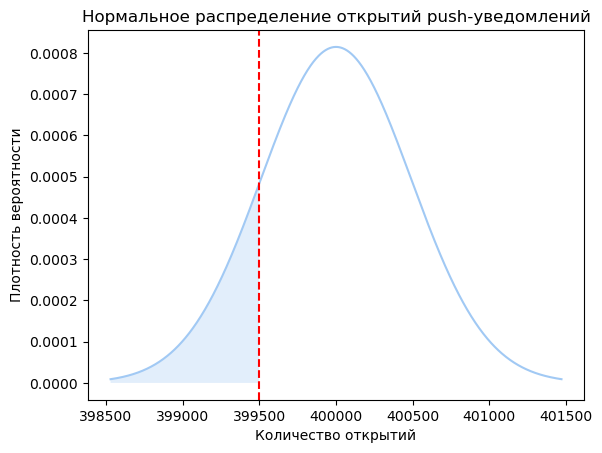

In [24]:
n_notifications = 1_000_000
p_open = 0.4
mean = n_notifications * p_open
std = np.sqrt(n_notifications * p_open * (1 - p_open))

target = 399_500
z_score = (target - mean) / std
prob = norm.cdf(z_score)

print("\033[1m"+"Вероятность открытий <= 399,500:",prob*100,"%"+"\033[1m")

# Визуализация
x = np.linspace(mean - 3*std, mean + 3*std, 1000)
plt.plot(x, norm.pdf(x, mean, std))
plt.axvline(target, color='red', linestyle='--')
plt.fill_between(x, 0, norm.pdf(x, mean, std), where=(x <= target), alpha=0.3)
plt.title('Нормальное распределение открытий push-уведомлений')
plt.xlabel('Количество открытий')
plt.ylabel('Плотность вероятности')
plt.show()

## Итоговые выводы :
- все данные состоят из 3-х блоков:
    * блока, идентифицирующего пользователй :имя, возраст, город, тип пользования (с подпиской/или без)
    * блока, описывающего сами поезки пользователей: дата, продолжительность аренды, расстояние, которое прехал пользователь
    * блока, описывающего условия аренды: стоимость подписки, стоимость минуты аренды, единовременный платеж при использовании аренды
- при обработке данных были произведены следующие преобразованиния:
    * были удаляем дубликаты в описании (блок 2). Была выявлена 31 избыточная запись
    
- анализ данных :
    * в базе предствалены пользователи из городов разной географической широты и разной численностью населения. Представлены более-менее равномерно (1534 / 8 городов = 192, разброс от эксремальных значений 25, либо, по другому, матожидание от среднего по городам имеет отклонение не более 13%)- выборка репрезентативна по этому параметру , при учете принятия условия однородности городов)
    * наибольшее количество пользователей в базе из Пятигорска - 219 человек
    * наименьшее количество пользователей в базе из Москвы - 168 человек
    * соотношение элементов базы идентифицирующей пользователей с свойством "подписка" (есть/нет) 45.57% / 54.43% . Приблизительно равномерны распределены -  можно сказать , что по этому параметру выборка репрезентативна
    * распределение клиентов по возрасту близко к нормальному - выборка репрезентативна по данному параметру
    * нет пользователей старше 43 лет. Границу осечения можно провести и по 36 годам: количество клиентов старше не значительно 
    * оценивая максимальные и минимальные значения выявлены группы пользователей младше 14 лет. Хотя по ПДД пользоваться самостоятельно они могут самокатами, однако фирмы проката в правилах прописали совершенолетний ценз. Сообщить заказчику о данной группе
    * за год пользователи берут в аренду самокат в среднем 12 раз.
    * пользователи берут в аренду самокаты приблизительно равномерно по месяцам при учете по всем городам (или так база была "собрана") как по количеству поездок , так и по суммарным расстояниям
    * среднее расстояние, которое проезжает клиент за один заказ - около 3100 м (среднее значение между медийным и арифметическим средним)
    * есть значительная группа заказов (в смысле возможного отдельного исследования) - заказы с расстоянием менее 1500 м
    * пользователи не используют самокаты более 40 минут
    *  среднее время аренды - около 17.8 минут (округляя , получится 18 минут)
    * явной корреляции между параметрами базы (расстояние, месяц, время) нет
- преобразование данных :
    * было произведено объединение баз данных для анализа совокупных параметров
    * из объединенной базы были выделены два датасета по признаку подписки (ultra/free)
- анализ объединенных данных :
    * в объединенной базе преобладают данные о поездках без подписки 68.83%/36.17%
    * количество поездок относительно времени у пользователей обоих групп распределено приблизительно одинаково в отрезке от 1 до 36 минут
    * пользовтели без подписки проезжают больше расстояний (на 1000 м) , чем без подписки
    * наблюдается тенденция пользования самокатом на расстояния около 1 км - возможно стоит исследовать причины и зависимости появления "горба" на графике
    * разброс  по расстояниям и продолжительности поездок больше у пользователй без подписки
    * приблизительно графики повторяют конфигурацию друг, друга , из чего можно сделать вывод , что поведение пользователй по этим параметрам приблизительно совпадает
    * общая выручка за год по всем клиентам "GoFast" 4 270 074 рублей
- анализ гипотез. Были выдвинуты следующие гипотезы :
    - пользователи с подпиской используют самокат  меньшее, чем пользователи без подписки
    
    - пользователи с подпиской проезжают не более 3130 
    
    - пользователи с подпиской тратят денег больше , чем пользователи без подписки
    
- были решены следующие задачи :
    - какое минимальное количество промокодов нужно разослать, чтобы вероятность была примерно 5 % не выполнить план: раздать промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку, монетизация происхлдит с вероятностью 10% 
    -* результат : нужно раздать 1172 купон, чтобы выполнить план с вероятностью около 95%
    - отдел планирует разослать 1 млн push уведомлений. вероятность, что уведомления откроют 40%. Нужно оценить вероятность того, что уведомление откроют не более 399,5 тыс
    -* результат : вероятность -  около 15.37 %
    

    
    

